In [61]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
from sklearn.base import BaseEstimator, TransformerMixin
import random
from PIL import Image
import requests
from io import BytesIO
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vynguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/sdhilip200/Content-Based-Recommendation---Good-Reads-data/master/data.csv", index_col = 0)

In [4]:
columns = ['Desc', 'author', 'genre', 'image_link', 'rating', 'title']

In [5]:
df = data[columns]
df.head()

,Desc,author,genre,image_link,rating,title
0,We know that power is shifting: From West to E...,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,Following the success of The Accidental Billio...,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,How to tap the power of social software and ne...,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,William J. Bernstein is an American financial ...,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,Amazing book. And I joined Steve Jobs and many...,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


In [69]:
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

df['cleaned'] = df['Desc'].apply(_removeNonAscii)

df['cleaned'] = df.cleaned.apply(func = make_lower_case)
df['cleaned'] = df.cleaned.apply(func = remove_stop_words)
df['cleaned'] = df.cleaned.apply(func=remove_punctuation)
df['cleaned'] = df.cleaned.apply(func=remove_html)
# df
class CleanText(BaseEstimator, TransformerMixin):
    def remove_urls(self, text):
        return re.sub(r'http.://[^\s]+[\s]?', '', text)
    def emoji_oneword(self, text):
        return text.replace('_','')
    def remove_punctuation(self, text):
        punct = string.punctuation
        
        trantab = str.maketrans(punct, len(punct)*' ')
        
        return text.translate(trantab)
    def remove_digits(self, text):
        return re.sub('\d+', '', text)
    def to_lower(self, text):
        return text.lower()

    def stemming(self, text):
        porter = PorterStemmer()
        words = text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    def fit(self, x, y = None, **fit_params):
        return self
    def transform(self, x, **transform_params):
        clean_x = x.apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.stemming)
        return clean_x
cleaning_data = CleanText()
cleaned_data = cleaning_data.transform(df["cleaned"])


In [71]:

corpus = []
for words in cleaned_data:
    corpus.append(words.split())

In [21]:
# https://www.kdnuggets.com/2020/08/content-based-recommendation-system-word-embeddings.html

In [22]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df = 5, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['cleaned'])

# Getting the words from the TF-IDF model

tfidf_list = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feature = tfidf.get_feature_names() # tfidf words/col-names

In [23]:
def recommendations(title):
    
    # Calling the function vectors

    vectors(df)
    
    # finding cosine similarity for the vectors

    cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # taking the title and book image link and store in new data frame called books
    books = df[['title', 'image_link']]
    #Reverse mapping of the index
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()
         
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    book_indices = [i[0] for i in sim_scores]
    recommend = books.iloc[book_indices]
    for index, row in recommend.iterrows():

        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['title'])

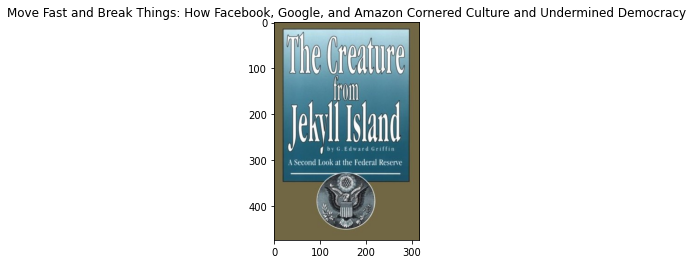

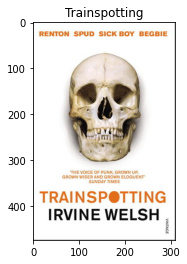

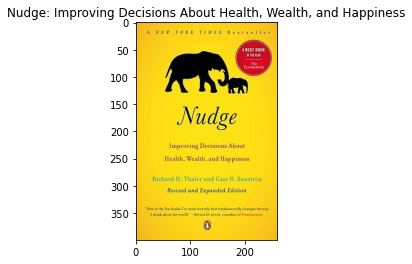

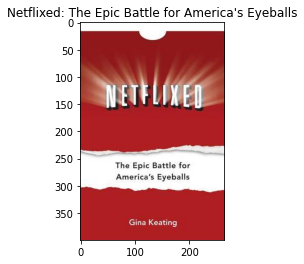

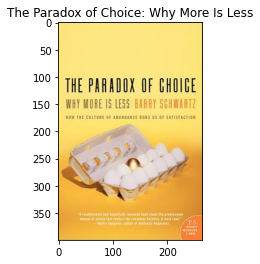

In [38]:
recommendations("The Road Ahead")

In [28]:
for i in df['title']:
    print(i)

The End of Power: From Boardrooms to Battlefields and Churches to States, Why Being In Charge Isn't What It Used to Be
Console Wars: Sega, Nintendo, and the Battle that Defined a Generation
Trust Agents: Using the Web to Build Influence, Improve Reputation, and Earn Trust
The Four Pillars of Investing
Made in Japan: Akio Morita and Sony
That Will Never Work: The Birth of Netflix and the Amazing Life of an Idea
The Man Who Solved the Market: How Jim Simons Launched the Quant Revolution
Bullshit Jobs: A Theory
Act Like a Leader, Think Like a Leader
Virtual Freedom: How to Work with Virtual Staff to Buy More Time, Become More Productive, and Build Your Dream Business
Competing for the Future
The Road Ahead
Principles of Marketing
Blockchain Revolution: How the Technology Behind Bitcoin Is Changing Money, Business, and the World
Be Our Guest: Perfecting the Art of Customer Service
When to Rob a Bank
Rich Dad's Retire Young, Retire Rich: How to Get Rich Quickly and Stay Rich Forever!
The Ra

Toyota Kata: Managing People for Improvement, Adaptiveness and Superior Results
The New Strategic Selling: The Unique Sales System Proven Successful by the World's Best Companies
Feel the Fear and Do It Anyway
Case in Point: Complete Case Interview Preparation
Trump: How to Get Rich
The Knowing-Doing Gap: How Smart Companies Turn Knowledge into Action
Funky Business: Talent Makes Capital Dance
The Alchemy of Finance
Words That Work: It's Not What You Say, It's What People Hear
Competing Against Time
The (Mis)Behavior of Markets
Data-Driven Marketing: The 15 Metrics Everyone in Marketing Should Know
Hot, Flat, and Crowded: Why We Need a Green Revolution – and How It Can Renew America
Entrepreneur Revolution: How to Develop Your Entrepreneurial Mindset and Start a Business That Works
UX for Lean Startups
The Connected Company
Where Are the Customers' Yachts?: Or a Good Hard Look at Wall Street
Whale Done!: The Power of Positive Relationships
Real Artists Don't Starve: Timeless Strategies

The One Thing: The Surprisingly Simple Truth Behind Extraordinary Results
The Long Tail: Why the Future of Business is Selling Less of More
Getting to Yes: Negotiating Agreement Without Giving In
To Sell Is Human: The Surprising Truth About Moving Others
Principles: Life and Work
The Art of War
Give and Take: A Revolutionary Approach to Success
The 48 Laws of Power
How Google Works
The Millionaire Next Door: The Surprising Secrets of America's Wealthy
Originals: How Non-Conformists Move the World
Flash Boys: A Wall Street Revolt
The Art of the Start: The Time-Tested, Battle-Hardened Guide for Anyone Starting Anything
Crush It!: Why Now Is the Time to Cash In on Your Passion
Measure What Matters
The Dip: A Little Book That Teaches You When to Quit (and When to Stick)
Contagious: Why Things Catch On
Essentialism: The Disciplined Pursuit of Less
Great by Choice: Uncertainty, Chaos, and Luck—Why Some Thrive Despite Them All
Barbarians at the Gate: The Fall of RJR Nabisco
The Checklist Mani

The Starbucks Experience: 5 Principles for Turning Ordinary Into Extraordinary
The Mom Test: How to talk to customers & learn if your business is a good idea when everyone is lying to you
Factfulness: Ten Reasons We're Wrong About the World – and Why Things Are Better Than You Think
A Book of Five Rings: The Classic Guide to Strategy
The Starfish and the Spider: The Unstoppable Power of Leaderless Organizations
Swim with the Sharks Without Being Eaten Alive: Outsell, Outmanage, Outmotivate, and Outnegotiate Your Competition
Ego Is the Enemy
The Presentation Secrets of Steve Jobs
Loonshots: How to Nurture the Crazy Ideas That Win Wars, Cure Diseases, and Transform Industries
Company of One: Why Staying Small Is the Next Big Thing for Business
Billion Dollar Whale: The Man Who Fooled Wall Street, Hollywood, and the World
Competing Against Luck
Gamestorming: A Playbook for Innovators, Rule-breakers, and Changemakers
Here Comes Everybody: The Power of Organizing Without Organizations
Marke

Me Before You
The Adventures of Tom Sawyer
Cat's Cradle
Emma
My Sister's Keeper
The Joy Luck Club
Atonement
The Shining
A Christmas Carol
Love in the Time of Cholera
The Golden Compass
Station Eleven
Atlas Shrugged
Wicked: The Life and Times of the Wicked Witch of the West
The Unbearable Lightness of Being
Beloved
Extremely Loud and Incredibly Close
The Secret History
A Storm of Swords
The Princess Bride
The Brothers Karamazov
Jurassic Park
The Pillars of the Earth
Things Fall Apart
And Then There Were None
Cloud Atlas
Gone with the Wind
The Brief Wondrous Life of Oscar Wao
Rebecca
The Stand
The Rosie Project
The Sun Also Rises
Watership Down
A Feast for Crows
Americanah
The Outsiders
The Odyssey
Les Misérables
The Secret Garden
New Moon
Kafka on the Shore
Where the Crawdads Sing
Outlander
Big Little Lies
On the Road
Persuasion
Neverwhere
11/22/63
The Lord of the Rings
Inferno
Eclipse
Norwegian Wood
Anne of Green Gables
The Hate U Give
Their Eyes Were Watching God
The Remains of the Da

The Lost Hero
Still Life
Red Queen
Children of Blood and Bone
Equal Rites
Something Borrowed
Dune Messiah
A Scanner Darkly
Darkly Dreaming Dexter
House Rules
Everything, Everything
The Light Fantastic
Silas Marner
Wolves of the Calla
Patriot Games
Hollow City
God Bless You, Mr. Rosewater
Bridget Jones: The Edge of Reason
Contact
Swing Time
Rich People Problems
Practical Magic
Throne of Glass
Burial Rites
The Selection
The Dharma Bums
This Side of Paradise
Childhood's End
Night Film
The Outsider
Shadow of Night
Dandelion Wine
The Book of Lost Things
Haunted
My Year of Rest and Relaxation
The Likeness
The Nickel Boys
コンビニ人間 [Konbini ningen]
Firestarter
The Girl in the Spider's Web
Stargirl
The Story of a New Name
Are You There God? It's Me, Margaret
The New York Trilogy
2666
Portnoy's Complaint
Needful Things
Guards! Guards!
Dear John
Club Dead
Balzac and the Little Chinese Seamstress
The Invention of Hugo Cabret
All the Ugly and Wonderful Things
City of Glass
Of Human Bondage
Saturday
A

In [81]:
df['cleaned'] = cleaned_data.values
df['cleaned']

0       know power shift west east north south preside...
1       follow success accid billionair moneyb come co...
2       tap power social softwar network build busi tr...
3       william bernstein american financ theorist neu...
4       amaz book join steve job mani akio morita fan ...
                              ...                        
2446    ralph robert su setenta ao tra la muert de su ...
2447    murder vicarag mark debut agatha christi unfla...
2448    john wyndham publish novel day triffid moder a...
2449    classic book reveal flanneri o connor one orig...
2450    imbu everi page frank mccourt s astound humor ...
Name: cleaned, Length: 2382, dtype: object

In [72]:
model = Word2Vec(window = 10, sg = 1, hs = 0, negative = 10, alpha = 0.03, min_alpha = 0.0007, seed = 14)
model.build_vocab(corpus, progress_per = 20)
model.train(corpus, total_examples = model.corpus_count, epochs = 10, report_delay = 1)
model.init_sims(replace=True)

In [43]:
x = model[model.wv.vocab]
x.shape
model

<ipython-input-43-6fcea272df4e>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  x = model[model.wv.vocab]


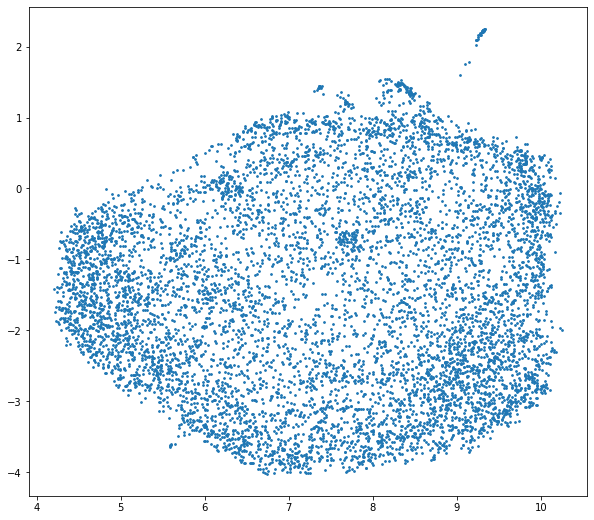

In [44]:
import umap.umap_ as umap
cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(x)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')


In [82]:

def vectors(x):
    
    # Creating a list for storing the vectors (description into vectors)
    global word_embeddings
    word_embeddings = []

    # Reading the each book description 
    for line in df['cleaned']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in model.wv.vocab:
                count += 1
                if avgword2vec is None:
                    avgword2vec = model[word]
                else:
                    avgword2vec = avgword2vec + model[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
        
            word_embeddings.append(avgword2vec)
    return word_embeddings

In [83]:

def recommendations(title):
    
    # Calling the function vectors

    array_embeddings = vectors(df)
    
    # finding cosine similarity for the vectors

    cosine_similarities = cosine_similarity(array_embeddings, array_embeddings)

    # taking the title and book image link and store in new data frame called books
    books = df[['title', 'image_link']]
    #Reverse mapping of the index
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()
         
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    book_indices = [i[0] for i in sim_scores]
    recommend = books.iloc[book_indices]
    for index, row in recommend.iterrows():

        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['title'])

<ipython-input-82-21d98665a563>:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  avgword2vec = model[word]
<ipython-input-82-21d98665a563>:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  avgword2vec = avgword2vec + model[word]


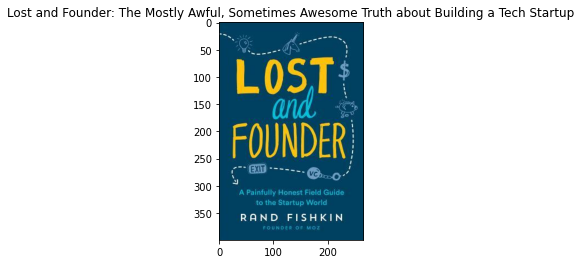

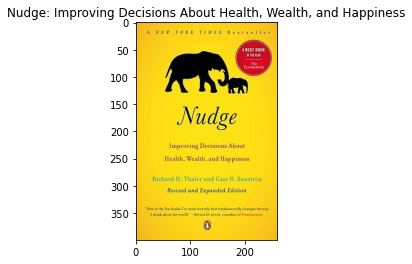

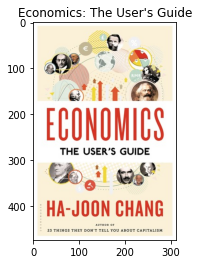

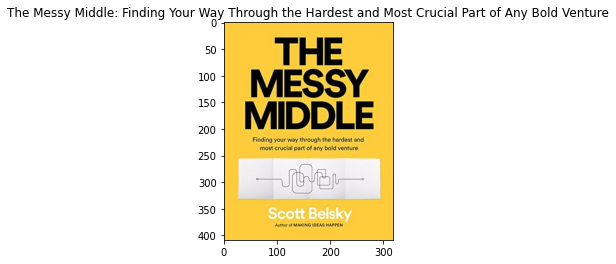

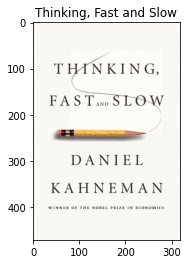

In [92]:
recommendations("The Leadership Challenge")